In [1]:
import tweepy
from textblob import TextBlob
import jsonpickle
import pandas as pd
import json
import csv
import nltk
import re

<H1>Hashtag_Scraping with Tweepy</H1>

In [2]:
#enter your api key
consumer_key = 'xxx'
consumer_secret = 'xxx'
access_token = 'xxx'
access_token_secret = 'xxx'     

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
auth.secure = True
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [3]:
searchQuery = '#tsla' #enter your desire hashtag
retweet_filter='-filter:retweets'

q=searchQuery+retweet_filter
tweetsPerQry = 100
fname = '_'.join(re.findall(r"#(\w+)", searchQuery))
sinceId = None
max_id = -1
maxTweets = 1000 #number of tweets you trying to scrape

In [4]:
tweetCount = 0
print("Downloading max {0} tweets".format(maxTweets))
with open('%s.csv' % (fname), 'wt', encoding="utf-8") as file:
    w = csv.writer(file)
    w.writerow(['timestamp', 'tweet_text', 'username', 'all_hashtags', 'followers_count', 'retweets_count', 'tweet_id'])
    while tweetCount < maxTweets:
        tweets = []
        try:
            if (max_id <= 0):
                if (not sinceId):
                    new_tweets = api.search(q=q, lang ="en", count=tweetsPerQry, tweet_mode='extended')

                else:
                    new_tweets = api.search(q=q, lang ="en", count=tweetsPerQry,
                                        since_id=sinceId, tweet_mode='extended')
            else:
                if (not sinceId):
                    new_tweets = api.search(q=q, lang ="en", count=tweetsPerQry,
                                        max_id=str(max_id - 1), tweet_mode='extended')
                else:
                    new_tweets = api.search(q=q, lang ="en", count=tweetsPerQry,
                                        max_id=str(max_id - 1),
                                        since_id=sinceId, tweet_mode='extended')

            if not new_tweets:
                print("No more tweets found")
                break
            for tweet in new_tweets:
                 w.writerow([tweet.created_at, tweet.full_text.replace('\n',' ').encode('utf-8'), tweet.user.screen_name.encode('utf-8'), [e['text'] for e in tweet._json['entities']['hashtags']], tweet.user.followers_count, tweet.retweet_count, tweet.id])

            tweetCount += len(new_tweets)
            print("Downloaded {0} tweets".format(tweetCount))
            max_id = new_tweets[-1].id
                
        except tweepy.TweepError as e:
            # Just exit if any error
            print("some error : " + str(e))
            break
                
print ("Downloaded {0} tweets, Saved to {1}".format(tweetCount, fname))

Downloaded 100 tweets
Downloaded 200 tweets
Downloaded 300 tweets
Downloaded 400 tweets
Downloaded 500 tweets
Downloaded 600 tweets
Downloaded 700 tweets
Downloaded 800 tweets
Downloaded 900 tweets
Downloaded 1000 tweets
Downloaded 1000 tweets, Saved to tsla


<h1> Clean scraped tweets </h1>

In [5]:
def clean(tweet):
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
    tweet = re.sub(r'#', '', tweet)
    tweet = re.sub(r'', '', tweet)
    tweet = re.sub(r'@[A-Za-z0–9]+', '', tweet)
    return tweet

def read_tweets(file_name):
    with open(file_name, 'r') as f:
        tweets = [clean(line.strip()) for line in f]
    f.close()
    return tweets

In [6]:
tweets = read_tweets('%s.csv' % (fname))
print(tweets[10])
print(TextBlob(tweets[10]).sentiment)

2021-05-08 00:06:27,b'69 Never forget the big winner and the big loser from the tsla short play... gme is payback',b'SO_OTRtire',"['tsla', 'gme']",19,0,1390820356617908227
Sentiment(polarity=0.0, subjectivity=0.16666666666666666)


<H1>Sentiment Analysis</H1>

In [7]:
polarity = lambda x: TextBlob(x).sentiment.polarity
subjectivity = lambda x: TextBlob(x).sentiment.subjectivity

In [8]:
import numpy as np

tweet_polarity = np.zeros(len(tweets))
tweet_subjectivity = np.zeros(len(tweets))

for idx, tweet in enumerate(tweets):
    tweet_polarity[idx] = polarity(tweet)
    tweet_subjectivity[idx] = subjectivity(tweet)

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

C:\Users\Gotwin\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


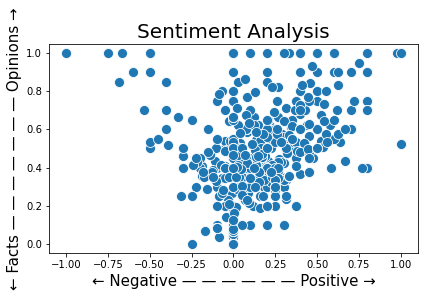

In [10]:
sns.scatterplot(tweet_polarity, # X-axis
                tweet_subjectivity,  # Y-axis
                s=100);


plt.title("Sentiment Analysis", fontsize = 20)
plt.xlabel('← Negative — — — — — — Positive →', fontsize=15)
plt.ylabel('← Facts — — — — — — — Opinions →', fontsize=15)
plt.tight_layout()

C:\Users\Gotwin\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Gotwin\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


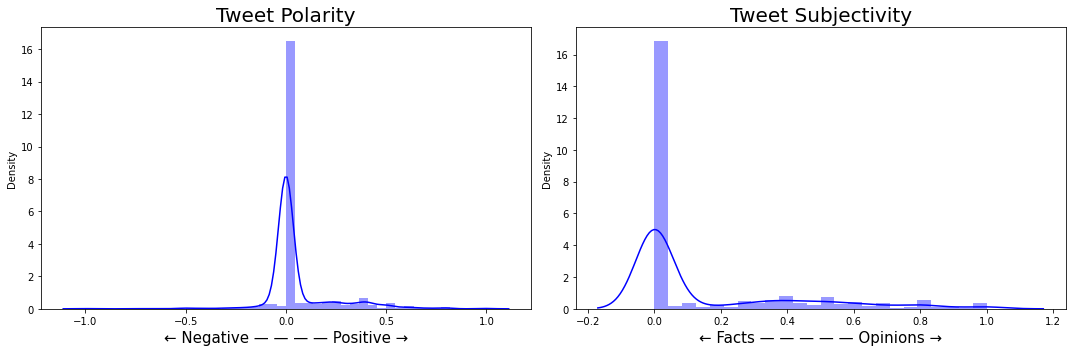

In [11]:
f, axs = plt.subplots(1, 2, figsize=(15,5))

sns.distplot(tweet_polarity, color="b", ax=axs[0])
axs[0].set_title("Tweet Polarity", fontsize = 20)
axs[0].set_xlabel('← Negative — — — — Positive →', fontsize=15)
sns.distplot(tweet_subjectivity, color="b", ax=axs[1])
axs[1].set_title("Tweet Subjectivity", fontsize = 20)
axs[1].set_xlabel('← Facts — — — — — Opinions →', fontsize=15)

plt.tight_layout()

In [12]:
tweets = tweepy.Cursor(api.search, q=searchQuery, lang='en').items(maxTweets)

polarity = 0

positive = 0
neutral = 0 
negative = 0

for tweet in tweets:
    final_text = tweet.text.replace('RT', '')
    if final_text.startswith(' @'):
        position = final_text.index(':')
        final_text = final_text[position+2:]
    if final_text.startswith(' @'):
        position = final_text.index(' ')
        final_text = final_text[position+2:]
#     polarity = lambda x: TextBlob(x).sentiment.polarity
    analysis = TextBlob(final_text)
    tweet_polarity = analysis.sentiment.polarity
    if tweet_polarity > 0.00:
        positive += 1
    elif tweet_polarity < 0.00:
        negative +=1
    elif tweet_polarity == 0.00:
        neutral += 1
    polarity += tweet_polarity        
    #polarity += analysis.sentiment.polarity
    
print(polarity)
print(f'Amount of positive tweets: {positive}')
print(f'Amount of negative tweets: {negative}')
print(f'Amount of neutral tweets: {neutral}')
if polarity > 10:
    print("According to the predictions and twitter sentiment analysis -> Investing in %s is a GREAT idea!" % str(searchQuery))
elif polarity < 10:
    print("According to the predictions and twitter sentiment analysis -> Investing in %s is a BAD idea!" % str(searchQuery))

105.52953706016221
Amount of positive tweets: 400
Amount of negative tweets: 77
Amount of neutral tweets: 523
According to the predictions and twitter sentiment analysis -> Investing in #tsla is a GREAT idea!
